In [218]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt

curr_directory = os.getcwd()

# Player Roster Information (Copied over from player_roster.ipynb)
teams = ['BOS','BRK','NYK','PHI','TOR','CHI','CLE','DET','IND','MIL','ATL','CHO','MIA','ORL','WAS',
         'DEN','MIN','OKC','POR','UTA','GSW','LAC','LAL','PHO','SAC','DAL','HOU','MEM','NOP','SAS']
        
# Dictionary of roster
# Ex. The roster of Boston Celtics players for the 2019-2020 season can be accessed using roster['BOS']['2019']
# It does not include any players/rookies for which there is no season data
roster = {}
    
for team in teams: 
    roster[team] = {}

# Initialize set for list of all players (with no repeats)
all_players = set()
    
for filename in os.listdir(os.path.join(curr_directory, 'data_sets/player_roster')):
    data = pd.read_csv(os.path.join('data_sets/player_roster', filename))
    year = filename[0:4]
    
    for team in teams:
        roster[team][year] = []
        
        players = data.loc[data['Tm'] == team]
        for ind in players.index: 
            player_name = players['Player'][ind].split('\\', 1)[0]
            if player_name not in roster[team][year]: 
                roster[team][year].append(player_name)
            
        all_players.update(roster[team][year])

num_players = len(all_players)
        
# Player dictionary that maps all players to index
player_index = dict(zip(list(all_players), range(len(all_players))))

In [219]:
# playbyplay_Data = pd.read_csv('/Users/baiyangwang/Box Sync/academics/maching learning/final-project/NBA-PBP-2018-2019.csv')

### What is the first column being loaded here? 
game_data = pd.read_csv(os.path.join(curr_directory,'data_sets/nba.games.stats.csv'))

# Sort all values by the Date
game_data = game_data.sort_values(by=['Date'])

In [220]:
# game has chronical order and Y shows score differential, X plus is team 1 payer
# X minus is team 2 player
game_results = np.array(list(game_data['TeamPoints'] - game_data['OpponentPoints']))
teams = np.array(list(zip(game_data.Team, game_data.Opponent)))
dates = np.array(list(game_data['Date']))

unique_dates = list(set(dates))

In [221]:
# Makes an index of all games that are repeated
repeat_indexes = []

for date in unique_dates: 
    same_day = np.where(dates == date)
    # suppose same_day = [0, 1, 2, 3, 4, 5]
    for i in same_day[0]: 
        # start with i = 0
        for j in same_day[0]: 
            # j = 0, 1, 2, 3, 4, 5
            if j > i: 
                if np.array_equal(np.flip(teams[j], axis=0) , teams[i]): 
                    repeat_indexes.append(j)

# Make new unique game results, teams and dates arrays
unique_game_results = game_results[repeat_indexes]
unique_teams = teams[repeat_indexes]
unique_dates = dates[repeat_indexes]

In [225]:
# Create a class for linear regression
class QuadraticRegression:
    def __init__(self, step_size=1e-5, max_iter=5000, eps=1e-4, theta=None, 
                  verbose=True):
        
        self.theta = theta
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        
    def getSAS(self):
        S = np.array(self.theta[0:962, 0:962])
        S2 = np.array(self.theta[963:1925, 963:1925])
        A = np.array(self.theta[0:962, 963:1925])
        A2 = np.array(self.theta[963:1925, 0:962])
        
        return S,S2,A,A2

    # Need to change this to x
    def predict(self, x):# teams, date):
        
        #S,S2,A,A2 = self.getSAS()
        #x, z = x_for_game(teams, date)
        #team_1_S = np.matmul(np.transpose(x), np.matmul(S, x))
        #team_2_S = np.matmul(np.transpose(z), np.matmul(S2, z))
        #cross_term_1 = np.matmul(np.transpose(x), np.matmul(A2, z))
        #cross_term_2 = np.matmul(np.transpose(z), np.matmul(A, x))
        
        if np.matmul(np.transpose(x), np.matmul(self.theta, x)) > 0:
            return 1
        else:
            return 0
    
    
    def sigmoid(self, z): 
        return 1.0 / (1 + np.exp(-z))
    
    def gradBatchLossFunction(self, x_teams, y_teams):
        
        update = 0
        theta = np.matrix(self.theta)
        S,S2,A,A2 = self.getSAS()
        
        for i in range(x_teams.shape[0]):
            x = np.matrix(x_teams[i,:])
            y = np.matrix(y_teams[i])   
            update += x.T*x*theta*x.T*x - x.T*y*x
        
        #add regularization terms-------------------------------   
        #temp = np.zeros(self.theta.shape)
        #temp[0:962, 0:962] = S-S.T
        #temp[963:1925, 963:1925] = S2-S2.T
        #temp[0:962, 963:1925] = A+A.T
        #temp[963:1925, 0:962] = A2+A2.T
        #update += 1*temp
        #temp[0:962, 0:962] = S+S2
        #temp[963:1925, 963:1925] = S+S2
        #temp[0:962, 963:1925] = A+A2
        #temp[963:1925, 0:962] = A+A2
        #update += 1*temp
        
            
        return update
    
    def gradminiBatchLossFunction(self, x_teams, y_teams, batch_size, index):
        
        update = 0
        theta = np.matrix(self.theta)
        S,S2,A,A2 = self.getSAS()
        
        for i in range(batch_size):
            x = np.matrix(x_teams[int((i+index)%x_teams.shape[0]),:])
            y = np.matrix(y_teams[int((i+index)%x_teams.shape[0])])   
            update += x.T*x*theta*x.T*x - x.T*y*x
            
        #add regularization terms-------------------------------    
        #temp = np.zeros(self.theta.shape)
        #temp[0:962, 0:962] = S-S.T
        #temp[963:1925, 963:1925] = S2-S2.T
        #temp[0:962, 963:1925] = A+A.T
        #temp[963:1925, 0:962] = A2+A2.T
        #update += 1*temp
        #temp[0:962, 0:962] = S+S2
        #temp[963:1925, 963:1925] = S+S2
        #temp[0:962, 963:1925] = A+A2
        #temp[963:1925, 0:962] = A+A2
        #update += 1*temp
            
        return update
    
    def fit(self, x, y, mini = False):
        iterations = 0
        abs_error = 1
        error_list = []
        batch_size = 32
        ind = 0
        
        if self.theta is None: 
            self.theta = np.zeros((2*num_players, 2*num_players))
        
        if mini == False:
            while iterations < self.max_iter and abs_error >= self.eps:
                error = self.step_size*self.gradBatchLossFunction(x, y)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                #self.theta = theta_new
                #------------------------------------------
                self.theta = self.project(theta_new)

                iterations += 1

                print('Error: {}'.format(abs_error))
        else:
            while iterations < self.max_iter and abs_error >= self.eps:
                error = self.step_size*self.gradminiBatchLossFunction(x, y, batch_size, ind)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                #self.theta = theta_new
                #-------------------------------------------
                self.theta = self.project(theta_new)

                iterations += 1
                ind += batch_size

                print('Error: {}'.format(abs_error))
        
        print('Convergence!')
        plt.plot(error_list)
        plt.show()
        
    def process_data(self, teams, dates, results): 
        num_games = teams.shape[0]

        # Create x for all games
        # To access x for 0th game -- x[:, 0] 
        x_without_intercept = np.zeros((num_games, 2*num_players))
        
        for i in range(num_games): 
            z, t = self.x_for_game(teams[i], dates[i])
            combined = np.vstack((z, t))
            x_without_intercept[i, :] = combined[:,0]
            
        #x = self.add_intercept(x_without_intercept)
        x = x_without_intercept
        
        # Create y for all games (if team A wins, y = 1; if team B wins, y = 0)
        y = np.zeros((num_games, 1))
        for i in range(num_games): 
            if results[i] > 0: 
                y[i] = 1
            else:
                y[i] = 0
                
        return x, y

    def x_for_game(self, teams, date): 
        x_1 = np.zeros((num_players, 1))
        x_2 = np.zeros((num_players, 1))

        if int(date[5:7]) < 9: 
            year = str(int(date[0:4]) - 1)
        else: 
            year = date[0:4]

        team_1_players = roster[teams[0]][year]
        for item in team_1_players: 
            x_1[player_index[item]] = 1

        team_2_players = roster[teams[1]][year]
        for item in team_2_players: 
            x_2[player_index[item]] = 1

        return x_1, x_2
    
    def add_intercept(self, x): 
        new_x = np.zeros((x.shape[0], x.shape[1]+1))
        new_x[:, 0] = 1
        new_x[:, 1:] = x
        
        return new_x
    
    def symmetrize(self, m):
        m = np.array(m)
        for i in range(m.shape[0]):
            for j in range(i,m.shape[1]):
                m[i][j] = m[j][i] = 0.5*(m[j][i] + m[i][j])
                
        return m
    
    def antisymmetrize(self, m):
        for i in range(m.shape[0]):
            for j in range(i,m.shape[1]):
                temp = m[i][j] - m[j][i]
                m[i][j] = 0.5*temp
                m[j][i] = -0.5*temp
                
        return m
    
    def project(self, m):
        m = np.array(m)
        side = m.shape[0]
        S = self.symmetrize(m[0:int(side/2-1),0:int(side/2-1)])
        S_minus = self.symmetrize(m[int(side/2):int(side-1),int(side/2):int(side-1)])

        A = self.antisymmetrize(m[0:int(side/2-1),int(side/2):int(side-1)])
        A_minus = self.antisymmetrize(m[int(side/2):int(side-1),0:int(side/2-1)])
        S_new = (S - S_minus)/2
        S_minus_new = (S_minus - S)/2
        
        if np.allclose(A, -1*A_minus, 1e-10, 1e-10):
            A_new = A
            A_minus_new = A_minus
        elif np.linalg.norm(A.T-A_minus) < np.linalg.norm(A-A_minus):
            A_new = 0.5*(A+A_minus)
            A_minus_new = A_new.T
        else:
            A_new = 0.5*(A+A_minus.T)
            A_minus_new = A_new.T
            
        M = np.zeros(m.shape)
        M[0:int(side/2-1),0:int(side/2-1)] = S_new
        M[int(side/2):int(side-1),int(side/2):int(side-1)] = S_minus_new
        M[0:int(side/2-1),int(side/2):int(side-1)] = A_new
        M[int(side/2):int(side-1),0:int(side/2-1)] = A_minus_new
        
        return M

In [226]:
# Load training set
test = QuadraticRegression()
x, y = test.process_data(unique_teams[0:50], unique_dates[0:50], unique_game_results[0:50])

Error: 0.0009884875229372162
Error: 0.0009747882311513124
Error: 0.0009613393886478941
Error: 0.0009481363306210243
Error: 0.0009351744922050351
Error: 0.0009224494067449413
Error: 0.0009099567041020752
Error: 0.0008976921089923923
Error: 0.0008856514393546575
Error: 0.0008738306047453489
Error: 0.0008622256047568006
Error: 0.0008508325274546614
Error: 0.0008396475478303247
Error: 0.0008286669262634589
Error: 0.0008178870069892416
Error: 0.0008073042165642908
Error: 0.0007969150623246514
Error: 0.0007867161308285065
Error: 0.0007767040862755566
Error: 0.0007668756688942823
Error: 0.0007572276932875113
Error: 0.0007477570467259946
Error: 0.0007384606873789322
Error: 0.0007293356424697596
Error: 0.0007203790063449077
Error: 0.0007115879384428439
Error: 0.000702959661150473
Error: 0.0006944914575340057
Error: 0.0006861806689317865
Error: 0.0006780246923973499
Error: 0.0006700209779822454
Error: 0.0006621670258500746
Error: 0.0006544603832156893
Error: 0.0006468986411068199
Error: 0.000639

Error: 0.00013743516983173772
Error: 0.00013682637947810166
Error: 0.00013622117989371633
Error: 0.00013561954383118057
Error: 0.0001350214443343413
Error: 0.00013442685473557937
Error: 0.00013383574865333622
Error: 0.00013324809998989723
Error: 0.0001326638829294589
Error: 0.00013208307193650955
Error: 0.00013150564175455357
Error: 0.00013093156740522237
Error: 0.0001303608241878174
Error: 0.00012979338767934144
Error: 0.00012922923373508198
Error: 0.00012866833848982845
Error: 0.0001281106783598144
Error: 0.0001275562300454968
Error: 0.00012700497053530805
Error: 0.00012645687711054278
Error: 0.0001259119273515765
Error: 0.00012537009914565542
Error: 0.00012483137069655022
Error: 0.00012429572053643286
Error: 0.00012376312754042195
Error: 0.00012323357094434558
Error: 0.0001227070303664095
Error: 0.0001221834858336348
Error: 0.00012166291781415466
Error: 0.00012114530725675542
Error: 0.00012063063563944225
Error: 0.00012011888502931748
Error: 0.00011961003815675625
Error: 0.000119104

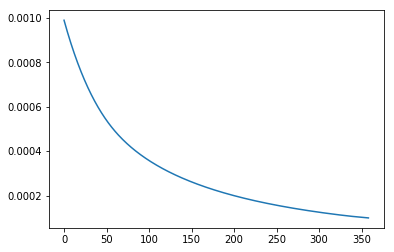

In [227]:
# Fit training set
test.fit(x, y, False)

True
True
True
True


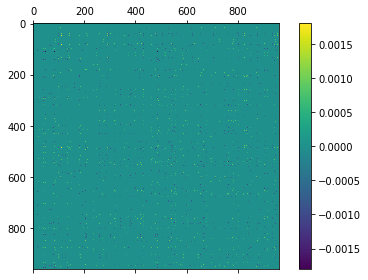

In [228]:
# Plot results
fig, ax = plt.subplots()
S,S2,A,A2 = test.getSAS()

# Check for symmetry
print(np.allclose(S, S.T, 1e-10, 1e-10))
print(np.allclose(-1*S, S2, 1e-10, 1e-10))
print(np.allclose(-1*A, A.T, 1e-10, 1e-10))
print(np.allclose(A2.T, -1*A2, 1e-10, 1e-10))

# Plot matrix
im = ax.matshow(A)
cbar = fig.colorbar(im)

fig.tight_layout()
plt.show()

In [229]:
# Load 2015 playoff data
playoff_data = pd.read_csv(os.path.join(curr_directory,'data_sets/2015_playoffs.csv'))

raw_playoff_results = np.array(list(playoff_data['PTS'] - playoff_data['PTS.1']))
raw_playoff_team_pairs = np.array(list(zip(playoff_data['Visitor/Neutral'], playoff_data['Home/Neutral'])))
raw_playoff_dates = np.array(list(playoff_data['Date']))

In [230]:
playoff_pairs = {}

for i in range(len(raw_playoff_team_pairs)): 
    team_1 = raw_playoff_team_pairs[i][0]
    team_2 = raw_playoff_team_pairs[i][1]
    if (team_1,team_2) in playoff_pairs.keys(): 
        # if results > 0 --> team A won --> +1
        # if results < 0 --> team B won --> -1
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_1,team_2] += 1
        else: 
            playoff_pairs[team_1,team_2] += -1
    elif (team_2,team_1) in playoff_pairs.keys():
        # if results > 0 --> team B won --> -1
        # if results < 0 --> team A won --> +1
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_2,team_1] += -1
        else: 
            playoff_pairs[team_2,team_1] += 1
    else: 
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_1,team_2] = 1
        else: 
            playoff_pairs[team_1,team_2] = -1
            
print(playoff_pairs)

{('WAS', 'TOR'): 4, ('NOP', 'GSW'): -4, ('MIL', 'CHI'): -2, ('DAL', 'HOU'): -3, ('BOS', 'CLE'): -4, ('BRK', 'ATL'): -2, ('POR', 'MEM'): -3, ('SAS', 'LAC'): -1, ('WAS', 'ATL'): -2, ('MEM', 'GSW'): -2, ('CHI', 'CLE'): -2, ('LAC', 'HOU'): -1, ('HOU', 'GSW'): -3, ('CLE', 'ATL'): 4, ('CLE', 'GSW'): -2}


In [231]:
playoff_teams = []
playoff_results = []
playoff_dates = []

for key in playoff_pairs: 
    playoff_teams.append([key[0], key[1]])
    playoff_results.append(playoff_pairs[key])
    playoff_dates.append('2015-04-10')
    
playoff_teams = np.array(playoff_teams)
playoff_results = np.array(playoff_results)
playoff_dates = np.array(playoff_dates)

    
playoff_x, playoff_y = test.process_data(playoff_teams, playoff_dates, playoff_results)

predicted_y = []
temp = playoff_x[0,:]
for i in range(playoff_x.shape[0]):
    x = playoff_x[i,:]    
    predicted_y.append(test.predict(x))

In [232]:
prediction_accuracy = np.mean(np.array(predicted_y) == np.array(playoff_y.T[0][:]))
print(prediction_accuracy)
print(predicted_y)
print(np.array(predicted_y) == np.array(playoff_y.T[0][:]))

0.4666666666666667
[0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0]
[False False False  True False  True False False  True  True False  True
  True False  True]


In [233]:
test_x, test_y = test.process_data(unique_teams[2230:3000], unique_dates[2230:3000], unique_game_results[2230:3000])

In [234]:
predicted_y = []
temp = test_x[0,:]
for i in range(test_x.shape[0]):
    x = test_x[i,:]    
    predicted_y.append(test.predict(x))
    
print(np.mean(np.array(predicted_y) == np.array(test_y.T)))

0.5467532467532468
